In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ls "/content/gdrive/MyDrive/Colab Notebooks/데이터 과학/ml-100k/ml-100k"

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [3]:
import torch
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [4]:
#파일 불러오기, 구분자 tab columns 이름
train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/데이터 과학/ml-100k/ml-100k/ua.base",
                    sep="\t", names=['user','movie','rating','timestamp'])
test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/데이터 과학/ml-100k/ml-100k/ua.test",
                   sep="\t", names=['user','movie','rating','timestamp'])


In [5]:
test

,user,movie,rating,timestamp
0,1,20,4,887431883
1,1,33,4,878542699
2,1,61,4,878542420
3,1,117,3,874965739
4,1,155,2,878542201
...,...,...,...,...
9425,943,232,4,888639867
9426,943,356,4,888639598
9427,943,570,1,888640125
9428,943,808,4,888639868


In [ ]:
train

,user,movie,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
90565,943,1047,2,875502146
90566,943,1074,4,888640250
90567,943,1188,3,888640250
90568,943,1228,3,888640275


In [ ]:
#pytorch tensor 데이터로 변환해야 학습 가능
items = torch.LongTensor(train['movie'])
users = torch.LongTensor(train['user'])
ratings = torch.FloatTensor(train['rating'])

items_test = torch.LongTensor(test['movie'])
users_test = torch.LongTensor(test['user'])
ratings_test = torch.FloatTensor(test['rating'])

In [ ]:
#rank 임의로 설정 가능, 10으로 설정
rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1
#user matrix
P = torch.randn(numItems, rank,requires_grad=True)
#item
Q = torch.randn(numUsers,rank, requires_grad=True)

In [ ]:
optimizer = torch.optim.Adam([P, Q], lr=0.1)

x = []
y = []

#test mse
y_test = []

#regularization 추가
lambda1 = 0.0001
lambda2 = 0.0001
#epoch: 900, cost: 0.460133
# lambda1 = 0.00001
# lambda2 = 0.00001
#성능 안좋음
# lambda1 = 0.001
# lambda2 = 0.001

for epoch in range(1000):
  hypothesis = torch.sum(P[items] * Q[users], dim=1)
  cost = F.mse_loss(hypothesis, ratings)
  loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2)


  optimizer.zero_grad()
  loss.backward()
  # cost.backward()
  optimizer.step()

  x.append(epoch)
  y.append(cost)

  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
    cost_test = F.mse_loss(hypo_test, ratings_test)
    y_test.append(cost_test)

  if epoch % 100 == 0:
    print("epoch: {}, cost: {:.6f}".format(epoch, cost.item()))

epoch: 0, cost: 12.956659
epoch: 100, cost: 0.630514
epoch: 200, cost: 0.626201
epoch: 300, cost: 0.625810
epoch: 400, cost: 0.625665
epoch: 500, cost: 0.625637
epoch: 600, cost: 0.625673
epoch: 700, cost: 0.625725
epoch: 800, cost: 0.625766
epoch: 900, cost: 0.625801


In [ ]:
#bias 추가
lambda3 = 0.001
lambda4 = 0.001
# epoch: 900, cost: 0.563926
# lambda3 = 0.00001
# lambda4 = 0.00001
#epoch: 900, cost: 0.572715
# lambda3 = 0.0001
# lambda4 = 0.0001
bias_item = torch.randn(numItems, requires_grad=True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

optimizer = torch.optim.Adam([P, Q, bias_item, bias_user], lr=0.1)

x = []
y = []

#test mse
y_test = []

#regularization 추가
lambda1 = 0.0001
lambda2 = 0.0001


for epoch in range(1000):
  hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
  cost = F.mse_loss(hypothesis, ratings)
  loss = cost + lambda1 * torch.sum(P ** 2) + lambda2 * torch.sum(Q ** 2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)


  optimizer.zero_grad()
  loss.backward()
  # cost.backward()
  optimizer.step()

  x.append(epoch)
  y.append(cost)

  with torch.no_grad():
    hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1)
    cost_test = F.mse_loss(hypo_test, ratings_test)
    y_test.append(cost_test)

  if epoch % 100 == 0:
    print("epoch: {}, cost: {:.6f}".format(epoch, cost.item()))

epoch: 0, cost: 14.263989
epoch: 100, cost: 0.619775
epoch: 200, cost: 0.608373
epoch: 300, cost: 0.606005
epoch: 400, cost: 0.604596
epoch: 500, cost: 0.603627
epoch: 600, cost: 0.602990
epoch: 700, cost: 0.602497
epoch: 800, cost: 0.602153
epoch: 900, cost: 0.601986


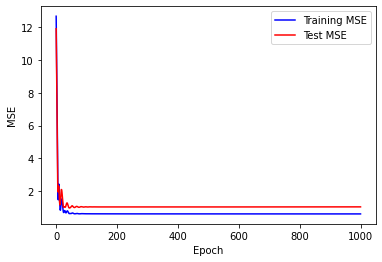

In [ ]:
#training mse 그려보기
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(x,y, c="blue", label="Training MSE")
#test mse 그려보기, over fitting 발생
plt.plot(x,y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

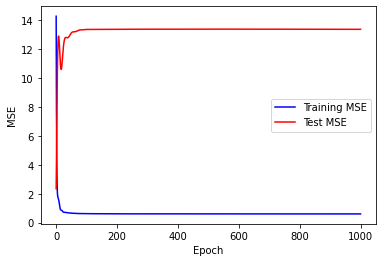

In [ ]:
#test mse 바꿨을 때
#training mse 그려보기
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(x,y, c="blue", label="Training MSE")
#test mse 그려보기, over fitting 발생
plt.plot(x,y_test, c="red", label="Test MSE")
plt.legend()
plt.show()